## About

In this notebook we prepare a simple solution for the [kaggle challenge on higgs.](https://inclass.kaggle.com/c/mlhep-2016-higgs-detection)

In [17]:
%matplotlib inline

In [29]:
!pip install --upgrade sklearn

Requirement already up-to-date: sklearn in /root/miniconda/envs/rep_py2/lib/python2.7/site-packages
Requirement already up-to-date: scikit-learn in /root/miniconda/envs/rep_py2/lib/python2.7/site-packages (from sklearn)
You are using pip version 8.1.1, however version 8.1.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
!pip install --upgrade pip

Requirement already up-to-date: pip in /root/miniconda/envs/rep_py2/lib/python2.7/site-packages


In [2]:
import matplotlib.pyplot as plt

import pandas
import numpy

from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.svm import LinearSVC
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel

### Download data

In [3]:
!cd datasets; wget -O public_train_10000.root -nc --no-check-certificate https://2016.mlhep.yandex.net/data/higgs/public_train_10000.root

wget: /root/miniconda/envs/rep_py2/lib/libcrypto.so.1.0.0: no version information available (required by wget)
wget: /root/miniconda/envs/rep_py2/lib/libssl.so.1.0.0: no version information available (required by wget)
File `public_train_10000.root' already there; not retrieving.


In [4]:
# you can download training sample with 100000 available events
# uncomment the below row
# !cd datasets; wget -O public_train_100000.root -nc --no-check-certificate https://2016.mlhep.yandex.net/data/higgs/public_train_100000.root

In [5]:
!cd datasets; wget -O public_test.root -nc --no-check-certificate https://2016.mlhep.yandex.net/data/higgs/public_test.root

wget: /root/miniconda/envs/rep_py2/lib/libcrypto.so.1.0.0: no version information available (required by wget)
wget: /root/miniconda/envs/rep_py2/lib/libssl.so.1.0.0: no version information available (required by wget)
File `public_test.root' already there; not retrieving.


### Read the smallest part of training file and test file

In [6]:
import root_numpy
data = pandas.DataFrame(root_numpy.root2array('datasets/public_train_10000.root'))
test = pandas.DataFrame(root_numpy.root2array('datasets/public_test.root'))

In [7]:
data.head()

,event_id,target,lepton_pt,lepton_eta,lepton_phi,mem_pt,mem_phi,jet1_pt,jet1_eta,jet1_phi,...,jet4_eta,jet4_phi,jet4_btag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb
0,1000001,1,34.750568,0.787025,1.898891,20.862434,-2.622998,44.814148,-0.168171,2.631595,...,0.877472,-0.256736,0.000000,81.724449,189.583145,80.118317,170.086075,91.128204,298.468781,374.685760
1,1000002,1,54.250927,-1.057915,2.310697,51.167873,2.545749,31.039040,-2.220276,-0.737298,...,-1.139118,-1.300325,2.000016,65.837746,201.096756,83.321556,208.039688,67.118484,287.363983,527.247559
2,1000003,1,47.746025,-0.783184,2.660325,68.165527,-1.700790,36.945312,-1.151738,-0.626912,...,-0.798898,-1.605550,2.000016,69.316925,156.334732,95.307602,149.089005,130.389206,237.879318,336.058838
3,1000004,0,45.950066,1.613817,0.964722,39.302082,-0.075989,84.307426,0.465748,2.287783,...,-0.586711,-2.256246,2.000023,71.032066,182.341537,81.941925,164.411148,93.709511,237.900055,392.807831
4,1000005,0,44.409187,-0.228907,-1.837974,49.886654,0.156533,32.852112,2.561646,2.641460,...,0.293522,1.391425,0.000000,122.030174,288.594086,84.386459,150.299744,69.818291,435.990356,533.977905


In [8]:
test[['jet1_pt','jet2_pt','jet3_pt','jet4_pt','jet1_btag','jet2_btag','jet3_btag','jet4_btag','mem_phi']]

,jet1_pt,jet2_pt,jet3_pt,jet4_pt,jet1_btag,jet2_btag,jet3_btag,jet4_btag,mem_phi
0,68.413330,28.192644,90.252411,35.200653,1.000008,0.000000,1.999937,0.000000,2.608772
1,118.127953,107.238831,68.670891,40.473949,0.000000,2.000016,0.000000,1.000000,1.214130
2,26.443583,154.289459,139.899277,24.017288,0.000000,0.999969,2.000016,0.000000,-2.354347
3,42.678413,42.376274,61.597656,37.422001,2.000000,0.000000,0.000000,2.000023,2.564890
4,164.289139,48.857182,32.992023,37.717247,1.999937,0.000000,0.000000,2.000023,1.125812
5,58.738194,79.737846,26.906214,35.224197,0.000000,2.000016,0.000000,1.000011,0.317960
6,17.313452,26.038296,26.366800,78.340408,0.000000,0.000000,2.000023,1.999937,-0.658289
7,21.353741,105.934952,89.945480,57.504173,2.000000,0.000000,1.000008,0.000000,-1.069838
8,43.196316,42.393520,38.787766,53.447411,2.000016,2.000000,0.000000,0.000000,2.922619
9,101.834137,49.829731,24.030119,66.792877,1.000011,0.000000,0.000000,0.000000,-2.952342


### Define training features

Exclude `event_id`, `target` from the features set

In [10]:
#data['pTBalance'] = data.jet1_pt + data.jet2_pt + data.jet3_pt + data.jet4_pt + data.lepton_pt + data.mem_pt
#data["Deltaj1j2"] = numpy.fabs(data.jet1_eta - data.jet2_eta)
#data["Deltaj3j4"] = numpy.fabs(data.jet3_eta - data.jet4_eta)
#data["Deltaj1j3"] = numpy.fabs(data.jet1_eta - data.jet3_eta)
#data["Deltaj2j4"] = numpy.fabs(data.jet2_eta - data.jet4_eta)
#data["DeltaPhij1j2"] = numpy.fabs(data.jet1_phi - data.jet2_phi)
#data["DeltaPhij3j4"] = numpy.fabs(data.jet3_phi - data.jet4_phi)
#data["DeltaPhij1j3"] = numpy.fabs(data.jet1_phi - data.jet3_phi)
#data["DeltaPhij2j4"] = numpy.fabs(data.jet2_phi - data.jet4_phi)
#data["DeltaPhij1l"] = numpy.fabs(data.jet1_phi - data.lepton_phi)
#data["DeltaPhij2l"] = numpy.fabs(data.jet2_phi - data.lepton_phi)
#data["DeltaPhij3l"] = numpy.fabs(data.jet3_phi - data.lepton_phi)
#data["DeltaPhij4l"] = numpy.fabs(data.jet4_phi - data.lepton_phi)
#data["DeltaEtaj1l"] = numpy.fabs(data.jet1_eta - data.lepton_eta)
#data["DeltaEtaj2l"] = numpy.fabs(data.jet2_eta - data.lepton_eta)
#data["DeltaEtaj3l"] = numpy.fabs(data.jet3_eta - data.lepton_eta)
#data["DeltaEtaj4l"] = numpy.fabs(data.jet4_eta - data.lepton_eta)
#data["DeltalMET"] = numpy.fabs(data.lepton_phi - data.mem_phi)
##data["Deltaj1j2"] = numpy.fabs(data.jet1_eta - data.jet2_eta)
#data['mSum'] =  data.m_jj + data.m_bb + data.m_lv
##test['pTBalance'] = test.jet1_pt + test.jet2_pt + test.jet3_pt + test.jet4_pt + test.lepton_pt + test.mem_pt
##test["Deltaj1j2"] = numpy.fabs(test.jet1_eta - test.jet2_eta)
##test["DeltalMET"] = numpy.fabs(test.lepton_phi - test.mem_phi)
#test['pTBalance'] = test.jet1_pt + test.jet2_pt + test.jet3_pt + test.jet4_pt + test.lepton_pt + test.mem_pt
#test["Deltaj1j2"] = numpy.fabs(test.jet1_eta - test.jet2_eta)
#test["Deltaj3j4"] = numpy.fabs(test.jet3_eta - test.jet4_eta)
#test["Deltaj1j3"] = numpy.fabs(test.jet1_eta - test.jet3_eta)
#test["Deltaj2j4"] = numpy.fabs(test.jet2_eta - test.jet4_eta)
#test["DeltaPhij1j2"] = numpy.fabs(test.jet1_phi - test.jet2_phi)
#test["DeltaPhij3j4"] = numpy.fabs(test.jet3_phi - test.jet4_phi)
#test["DeltaPhij1j3"] = numpy.fabs(test.jet1_phi - test.jet3_phi)
#test["DeltaPhij2j4"] = numpy.fabs(test.jet2_phi - test.jet4_phi)
#test["DeltaPhij1l"] = numpy.fabs(test.jet1_phi - test.lepton_phi)
#test["DeltaPhij2l"] = numpy.fabs(test.jet2_phi - test.lepton_phi)
#test["DeltaPhij3l"] = numpy.fabs(test.jet3_phi - test.lepton_phi)
#test["DeltaPhij4l"] = numpy.fabs(test.jet4_phi - test.lepton_phi)
#test["DeltaEtaj1l"] = numpy.fabs(test.jet1_eta - test.lepton_eta)
#test["DeltaEtaj2l"] = numpy.fabs(test.jet2_eta - test.lepton_eta)
#test["DeltaEtaj3l"] = numpy.fabs(test.jet3_eta - test.lepton_eta)
#test["DeltaEtaj4l"] = numpy.fabs(test.jet4_eta - test.lepton_eta)
#test["DeltalMET"] = numpy.fabs(test.lepton_phi - test.mem_phi)
##test["Deltaj1j2"] = numpy.fabs(test.jet1_eta - test.jet2_eta)
#test['mSum'] =  test.m_jj + test.m_bb + test.m_lv


features1 = list(set(data.columns) - {'event_id', 'target'})
features1


['jet3_pt',
 'jet3_eta',
 'm_jjj',
 'mem_phi',
 'jet1_pt',
 'jet4_phi',
 'jet1_phi',
 'jet2_eta',
 'jet3_btag',
 'm_jlv',
 'm_wbb',
 'jet4_pt',
 'jet4_btag',
 'jet2_pt',
 'jet1_btag',
 'm_jj',
 'm_wwbb',
 'jet2_phi',
 'lepton_phi',
 'm_bb',
 'm_lv',
 'jet4_eta',
 'jet2_btag',
 'lepton_pt',
 'mem_pt',
 'lepton_eta',
 'jet3_phi',
 'jet1_eta']

In [142]:
phis = [data.lepton_phi,data.mem_phi,data.jet1_phi,data.jet2_phi,data.jet3_phi,data.jet4_phi]
etas = [data.lepton_eta,data.lepton_eta,data.jet1_eta,data.jet2_eta,data.jet3_eta,data.jet4_eta]
pts = [data.lepton_pt,data.lepton_pt,data.jet1_pt,data.jet2_pt,data.jet3_pt,data.jet4_pt]
btags = [data.jet1_btag,data.jet2_btag,data.jet3_btag,data.jet4_btag]
jetPts = [data.jet1_pt,data.jet2_pt,data.jet3_pt,data.jet4_pt]

phis_t = [test.lepton_phi,test.mem_phi,test.jet1_phi,test.jet2_phi,test.jet3_phi,test.jet4_phi]
etas_t = [test.lepton_eta,test.lepton_eta,test.jet1_eta,test.jet2_eta,test.jet3_eta,test.jet4_eta]
pts_t = [test.lepton_pt,test.lepton_pt,test.jet1_pt,test.jet2_pt,test.jet3_pt,test.jet4_pt]
btags_t = [test.jet1_btag,test.jet2_btag,test.jet3_btag,test.jet4_btag]
jetPts_t = [test.jet1_pt,test.jet2_pt,test.jet3_pt,test.jet4_pt]

name = ["l","nu","j1","j2","j3","j4"]

#data["d_lnu"]= DistanceBetweenObjets(phis[0],etas[0],phis[1],phis[1])
#data["d_lnu"]= DistanceBetweenObjets(phis[0],etas[0],phis[1],phis[1])

massbb = [] 
massbj = [] 
masswh = [] 

for i in range(len(phis)):
    for j in range(len(phis)):
        if j > i:
            n = "d_" + name[i] + "_" + name[j]
            data[n] = DistanceBetweenObjets(phis[i],etas[i],phis[j],phis[j])            
            test[n] = DistanceBetweenObjets(phis_t[i],etas_t[i],phis_t[j],phis_t[j])
            if j > 1: 
                nb = "d1btag_" + name[i] + "_" + name[j]
                columnName = "jet" + str(j - 1) + "_btag"
                data[nb] = numpy.where(data[columnName] > 0.5, DistanceBetweenObjets(phis[i],etas[i],phis[j],etas[j]),0)
                test[nb] = numpy.where(test[columnName] > 0.5, DistanceBetweenObjets(phis_t[i],etas_t[i],phis_t[j],etas_t[j]), 0) 
                mb = "Mb_" + name[i] + "_" + name[j]
                massbj.append(mb)
                data[mb] = numpy.where(data[columnName] > 0.5, 
                                       InvariantMass(pts[i],phis[i],etas[i],pts[j],phis[j],etas[j]),0)
                test[mb] = numpy.where(test[columnName] > 0.5, 
                                       InvariantMass(pts_t[i],phis_t[i],etas_t[i],pts_t[j],phis_t[j],etas_t[j]), 0) 
                
            if i > 1:
                nb2 = "d2btag_" + name[i] + "_" + name[j]
                columnName1 = "jet" + str(j - 1) + "_btag"
                columnName2 = "jet" + str(i - 1) + "_btag"
                data[nb2] = numpy.where((data[columnName1] > 0.5) & (data[columnName2] > 0.5), 
                                        DistanceBetweenObjets(phis[i],etas[i],phis[j],etas[j]), 0)            
                test[nb2] = numpy.where((test[columnName1] > 0.5) & (test[columnName2] > 0.5), 
                                        DistanceBetweenObjets(phis_t[i],etas_t[i],phis_t[j],etas_t[j]), 0)
                mbb = "Mbb_" + name[i] + "_" + name[j]
                massbb.append(mbb)
                data[mbb] = numpy.where((data[columnName1] > 0.5) & (data[columnName2] > 0.5), 
                                        InvariantMass(pts[i],phis[i],etas[i],pts[j],phis[j],etas[j]), 0) 
                test[mbb] = numpy.where((test[columnName1] > 0.5) & (test[columnName2] > 0.5), 
                                        InvariantMass(pts_t[i],phis_t[i],etas_t[i],pts_t[j],phis_t[j],etas_t[j]), 0)
                mw = "MWh_" + name[i] + "_" + name[j]
                masswh.append(mw)
                data[mw] = numpy.where((data[columnName1] < 0.5) & (data[columnName2] < 0.5), 
                                        InvariantMass(pts[i],phis[i],etas[i],pts[j],phis[j],etas[j]), 0) 
                test[mw] = numpy.where((test[columnName1] < 0.5) & (test[columnName2] < 0.5), 
                                        InvariantMass(pts_t[i],phis_t[i],etas_t[i],pts_t[j],phis_t[j],etas_t[j]), 0)
                
data["MWl"] = InvariantMass(pts[1],phis[1],etas[1],pts[0],phis[0],etas[0])
test["MWl"] = InvariantMass(pts_t[1],phis_t[1],etas_t[1],pts_t[0],phis_t[0],etas_t[0])
data["MWlT"] = InvariantMass(pts[1],phis[1],0,pts[0],phis[0],0)
test["MWlT"] = InvariantMass(pts_t[1],phis_t[1],0,pts_t[0],phis_t[0],0)
                
data["HT"]=data.lepton_pt
for j in jetPts:
    data["HT"]+=j

test["HT"]=test.lepton_pt
for j in jetPts_t:
    test["HT"]+=j
    
data["LeadingJet"]=data[['jet1_pt','jet2_pt','jet3_pt','jet4_pt']].max(axis=1)
test["LeadingJet"]=test[['jet1_pt','jet2_pt','jet3_pt','jet4_pt']].max(axis=1)

indexMax_d = data[['jet1_pt','jet2_pt','jet3_pt','jet4_pt']].idxmax(axis=1)
indexMax_t = test[['jet1_pt','jet2_pt','jet3_pt','jet4_pt']].idxmax(axis=1)

LowMassCut = 125-30
HighMassCut = 125 + 30
data["nMHiggs_30"]= 0
test["nMHiggs_30"]= 0
for h in massbb:
    data["nMHiggs_30"]=numpy.where((data[h] > LowMassCut) & (data[h] < HighMassCut), data["nMHiggs_30"]  + 1, 0)
    test["nMHiggs_30"]=numpy.where((test[h] > LowMassCut) & (test[h] < HighMassCut), test["nMHiggs_30"]  + 1, 0)

LowMassCut = 125-30
HighMassCut = 125 + 30
data["nMHiggsbj_30"]= 0
test["nMHiggsbj_30"]= 0
for h in massbj:
    data["nMHiggsbj_30"]=numpy.where((data[h] > LowMassCut) & (data[h] < HighMassCut), data["nMHiggsbj_30"]  + 1, 0)
    test["nMHiggsbj_30"]=numpy.where((test[h] > LowMassCut) & (test[h] < HighMassCut), test["nMHiggsbj_30"]  + 1, 0)
    
LowMassCut = 80-20
HighMassCut = 80 + 20
data["nMW_20"]= 0
test["nMW_20"]= 0
j1 = -1
j2 = -1
minimalDifferenceWMass = 100
for w in masswh:
    #d = numpy.abs(data[w]-80)
    #if d < minimalDifferenceWMass:
    #    j1 = w[5]
    #    j2 = w[8]
    data["nMW_20"]=numpy.where((data[w] > LowMassCut) & (data[w] < HighMassCut), data["nMW_20"]  + 1, 0)
    test["nMW_20"]=numpy.where((test[w] > LowMassCut) & (test[w] < HighMassCut), test["nMW_20"]  + 1, 0)

NameError: name 'DistanceBetweenObjets' is not defined

In [102]:
from itertools import product
features = data.drop("target", axis=1).astype(numpy.float64)
jet_features = list(filter(lambda feature: feature.startswith("jet"), features.columns))
lepton_features = list(filter(lambda feature: feature.startswith("lepton"), features.columns))
print jet_features
jet_pairs = frozenset(filter(lambda pair:len(pair) == 2, map(frozenset, product(range(1,5), range(1,5)))))
print jet_pairs

distances = []
distances_bb = []
for jet_pair in jet_pairs:
    jet1, jet2 = jet_pair
    print "jetR_%d_%d" % (jet1,jet2)
    data['jetR_%d_%d' % (jet1,jet2)]=(
           ((features["jet%d_eta" % jet1] - features["jet%d_eta" % jet2])**2 +
           (features["jet%d_phi" % jet1] - features["jet%d_phi" % jet2])**2 ))
    data['jetRbb_%d_%d' % (jet1,jet2)]=(
           ((features["jet%d_eta" % jet1] - features["jet%d_eta" % jet2])**2 +
           (features["jet%d_phi" % jet1] - features["jet%d_phi" % jet2])**2 )*(
            (features["jet%d_btag" % jet1]>0.5) & (features["jet%d_btag" % jet2]>0.5)))

#distances_df = pandas.concat(distances, axis=1)
#distances_df.columns=list(map(lambda pair: "d^2(%d, %d)" % tuple(pair), jet_pairs))
#distances_df.head()

#distances_bb_df = pandas.concat(distances_bb, axis=1)
#distances_bb_df.columns=list(map(lambda pair: "d^2(%d, %d)" % tuple(pair), jet_pairs))
#distances_bb_df.head()    

features = list(set(data.columns) - {'event_id', 'target'})
print  features    


['jet1_pt', 'jet1_eta', 'jet1_phi', 'jet1_btag', 'jet2_pt', 'jet2_eta', 'jet2_phi', 'jet2_btag', 'jet3_pt', 'jet3_eta', 'jet3_phi', 'jet3_btag', 'jet4_pt', 'jet4_eta', 'jet4_phi', 'jet4_btag']
frozenset([frozenset([2, 4]), frozenset([1, 2]), frozenset([1, 4]), frozenset([3, 4]), frozenset([2, 3]), frozenset([1, 3])])
jetR_2_4
jetR_1_2
jetR_1_4
jetR_3_4
jetR_2_3
jetR_1_3
['jet3_pt', 'jet3_eta', 'jetR_3_4', 'jet2_pt', 'mem_phi', 'jet1_pt', 'jetRbb_1_4', 'jet4_phi', 'jetRbb_1_2', 'jetRbb_1_3', 'jetRbb_2_3', 'jetRbb_2_4', 'jet1_phi', 'jet2_eta', 'jet3_btag', 'm_jlv', 'jetR_1_4', 'jetR_1_2', 'jetR_1_3', 'jetR_2_3', 'm_wbb', 'jet4_pt', 'jetR_2_4', 'jet4_btag', 'm_jjj', 'jet1_btag', 'm_jj', 'm_wwbb', 'jet2_phi', 'lepton_phi', 'm_bb', 'm_lv', 'jet4_eta', 'jet2_btag', 'jetRbb_3_4', 'lepton_pt', 'mem_pt', 'lepton_eta', 'jet3_phi', 'jet1_eta']


In [89]:
test['diff_phi_jets12'] = test.jet1_phi - test.jet2_phi

### Prepare high-level features for training

In [103]:
high_level_features1 = ['distances_bb', 'mSum','DeltalMET','pTBalance','Deltaj1j2',
                       'Deltaj2j4','Deltaj1j3','Deltaj3j4',
                       'DeltaPhij1j2','DeltaPhij3j4','DeltaPhij1j3','DeltaPhij2j4',
                       'DeltaPhij1l','DeltaPhij2l','DeltaPhij3l','DeltaPhij4l',
                       'DeltaEtaj1l','DeltaEtaj2l','DeltaEtaj3l','DeltaEtaj4l',]
high_level_features2 = ['distances_bb',
  'jet1_pt','jet1_eta','jet2_pt',
 'jet2_eta','jet3_pt', 'jet3_eta','jet4_pt','jet4_eta',
    'jet2_phi','jet1_phi', 'jet3_phi','jet4_phi',
    'lepton_pt','lepton_phi','lepton_eta',
  'mem_pt','mem_phi',
#'jet1_btag','jet2_btag','jet3_btag','jet4_btag',          
  'm_jj', 'm_jjj', 'm_jlv', 'm_wwbb', 'm_bb', 'm_wbb', 'm_lv']
high_level_features3 = [
    'lepton_pt','lepton_phi','lepton_eta',
  'mem_pt','mem_phi',
#'jet1_btag','jet2_btag','jet3_btag','jet4_btag',          
  'm_jj', 'm_jjj', 'm_jlv', 'm_wwbb', 'm_bb', 'm_wbb', 'm_lv']
high_level_features = features
print high_level_features
jet_features
#jet_pairs
#features

['jet3_pt', 'jet3_eta', 'jetR_3_4', 'jet2_pt', 'mem_phi', 'jet1_pt', 'jetRbb_1_4', 'jet4_phi', 'jetRbb_1_2', 'jetRbb_1_3', 'jetRbb_2_3', 'jetRbb_2_4', 'jet1_phi', 'jet2_eta', 'jet3_btag', 'm_jlv', 'jetR_1_4', 'jetR_1_2', 'jetR_1_3', 'jetR_2_3', 'm_wbb', 'jet4_pt', 'jetR_2_4', 'jet4_btag', 'm_jjj', 'jet1_btag', 'm_jj', 'm_wwbb', 'jet2_phi', 'lepton_phi', 'm_bb', 'm_lv', 'jet4_eta', 'jet2_btag', 'jetRbb_3_4', 'lepton_pt', 'mem_pt', 'lepton_eta', 'jet3_phi', 'jet1_eta']


['jet1_pt',
 'jet1_eta',
 'jet1_phi',
 'jet1_btag',
 'jet2_pt',
 'jet2_eta',
 'jet2_phi',
 'jet2_btag',
 'jet3_pt',
 'jet3_eta',
 'jet3_phi',
 'jet3_btag',
 'jet4_pt',
 'jet4_eta',
 'jet4_phi',
 'jet4_btag']

In [82]:
jet_features

['jet1_pt',
 'jet1_eta',
 'jet1_phi',
 'jet1_btag',
 'jet2_pt',
 'jet2_eta',
 'jet2_phi',
 'jet2_btag',
 'jet3_pt',
 'jet3_eta',
 'jet3_phi',
 'jet3_btag',
 'jet4_pt',
 'jet4_eta',
 'jet4_phi',
 'jet4_btag']

### Plot histograms for each high-level feature

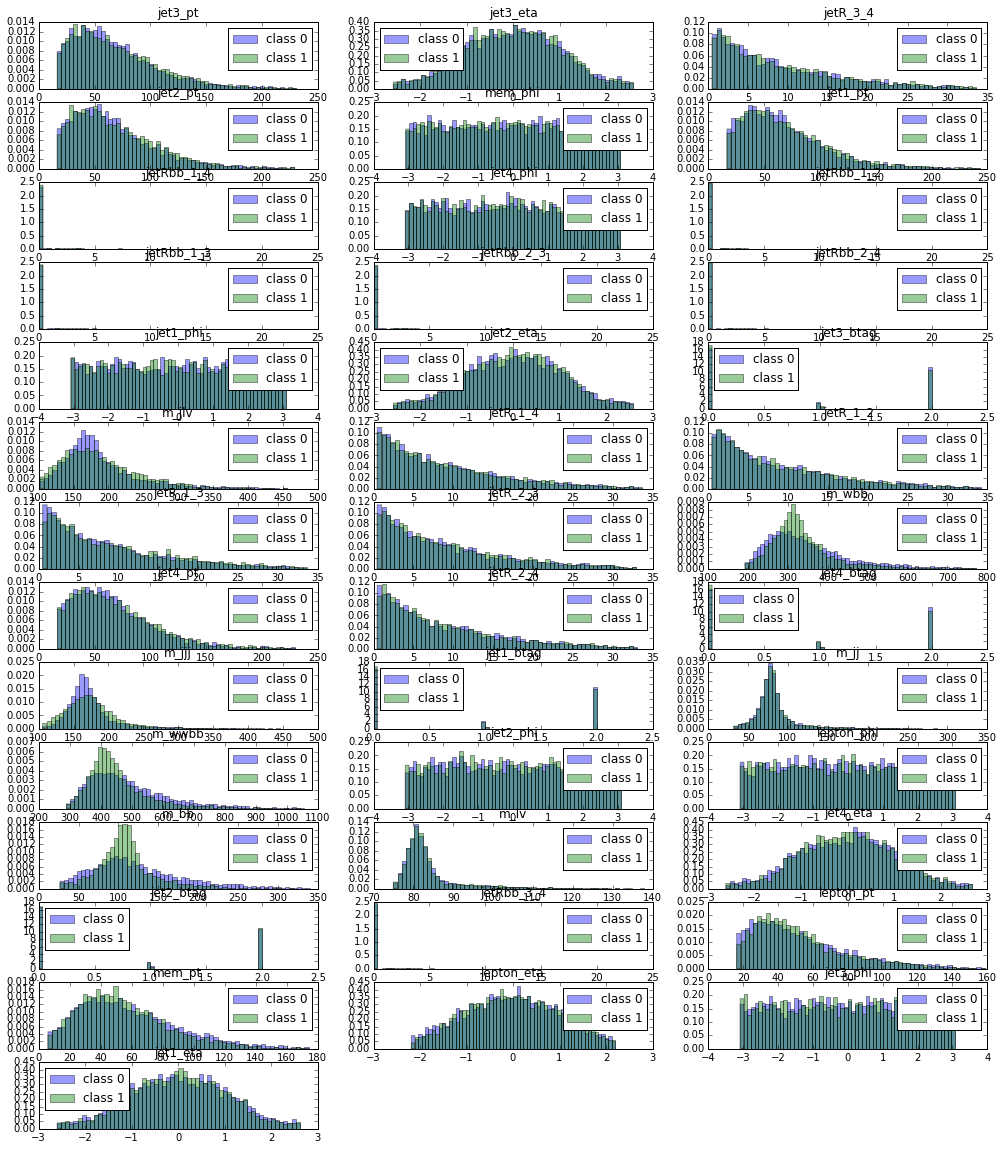

In [104]:
hist_params = {'normed': True, 'bins': 60, 'alpha': 0.4}
# create the figure
plt.figure(figsize=(17, 27))
for n, feature in enumerate(high_level_features):
    # add sub plot on our figure
    plt.subplot(len(features) // 5 + 11, 3, n+1)
    # define range for histograms by cutting 1% of data from both ends
    min_value, max_value = numpy.percentile(data[feature], [1, 99])
    plt.hist(data.ix[data.target.values == 0, feature].values, range=(min_value, max_value), 
             label='class 0', **hist_params)
    plt.hist(data.ix[data.target.values == 1, feature].values, range=(min_value, max_value), 
             label='class 1', **hist_params)
    plt.legend(loc='best')
    plt.title(feature)

### Divide training data into 2 parts 
`train_test_split` function is used to divide into 2 parts to preserve quality overestimating.

In [105]:
training_data, validation_data = train_test_split(data, random_state=11, train_size=0.8)

### Simple knn from `sklearn` training

In [129]:
### from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
#tree = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=20,
#(class_weight=None, criterion='gini', max_depth=20,
#        max_features=21, max_leaf_nodes=50, min_samples_leaf=10,
#                min_samples_split=7, min_weight_fraction_leaf=0.0,
#            random_state=None, splitter='best'
 
tree = GradientBoostingClassifier(init=None, learning_rate=0.4, loss='deviance',
              max_depth=3, max_features=30, max_leaf_nodes=3,
              min_samples_leaf=1, min_samples_split=3,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              random_state=None, subsample=1.0, verbose=0,
              warm_start=True)
tree = BaggingClassifier(base_estimator=tree)
tree.fit(training_data[high_level_features],training_data.target)
#knn = KNeighborsClassifier(n_neighbors=6)
#knn.fit(training_data[high_level_features], training_data.target)

BaggingClassifier(base_estimator=GradientBoostingClassifier(init=None, learning_rate=0.4, loss='deviance',
              max_depth=3, max_features=30, max_leaf_nodes=3,
              min_samples_leaf=1, min_samples_split=3,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=True),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=10, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [130]:
# predict validation sample (probability for each event)
proba = tree.predict_proba(validation_data[high_level_features])

In [131]:
learning_curve = []
for proba1 in tree.staged_predict_proba(validation_data[high_level_features]):
    learning_curve.append(roc_auc_score(validation_data.target, proba1[:, 1]))

AttributeError: 'BaggingClassifier' object has no attribute 'staged_predict_proba'

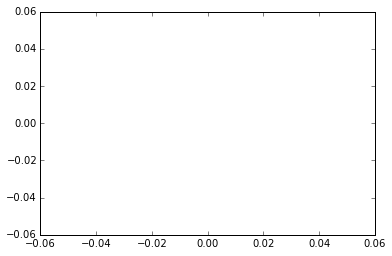

In [132]:
plt.plot(numpy.arange(len(learning_curve)), learning_curve)

In [133]:
proba
roc_auc_score(validation_data.target, proba[:, 1])

0.77933039735762177

In [139]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import root_pandas
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from rep.estimators import XGBoostClassifier
# XGBoostClassifier is parrallel inside
#xgboost_cv = cross_val_score(XGBoostClassifier(n_estimators=200, nthreads=16, num_feature=21,
#                                               gamma=None, eta=0.3, max_depth=10, scale_pos_weight=1.0,
#                                               min_child_weight=1.0, subsample=1.0, colsample=1.0, 
#                                              base_score=0.5, verbose=0, missing=-999.0, random_state=0),
#                             training_data[high_level_features].astype(np.float64),
#                             training_data["target"].astype(np.int64), cv=10, scoring="roc_auc")
#print(xgboost_cv.mean(), xgboost_cv.std())
#from XGBoostClassifier import XGBoostClassifier
#xgb = XGBoostClassifier(watchlist=[(test_x, test_y)],
#                       max_samples=0.9,
#                        n_iter=105,
#                        random_state=1335)

from sklearn.ensemble import BaggingClassifier

tree1 = XGBoostClassifier(features=high_level_features, n_estimators=100, nthreads=50, num_feature=22, 
                          gamma=None, eta=0.1, max_depth=10, scale_pos_weight=1.0, min_child_weight=1.0, 
                          subsample=1.0, colsample=1.0, base_score=0.5, verbose=0, missing=-999.0, 
                          random_state=0)
tree1 = BaggingClassifier(base_estimator=tree1)

tree1.fit(training_data[high_level_features].astype(np.float64),training_data.target,sample_weight=None)
proba1 = tree1.predict_proba(validation_data[high_level_features].astype(np.float64))
roc_auc_score(validation_data.target, proba1[:, 1])

UndefinedVariableError: name 'jet3_pt' is not defined

In [140]:
#learning_curve1 = []
#for proba2 in tree1.staged_predict_proba(validation_data[high_level_features].astype(np.float64)):
#    learning_curve1.append(roc_auc_score(validation_data.target, proba2[:, 1]))
#plt.plot(numpy.arange(len(learning_curve1)), learning_curve1)
#plt.show()

### Compute quality (ROC AUC) on the validation set (to prevent overestimating quality)

ValueError: The underlying estimator BaggingClassifier has no `coef_` or `feature_importances_` attribute. Either pass a fitted estimator to SelectFromModel or call fit before calling transform.

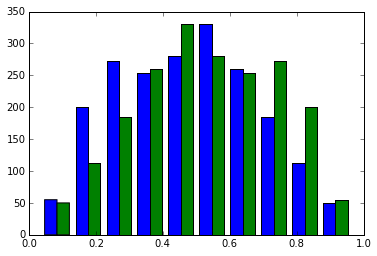

In [141]:
# take probability to be 1 class to compute ROC AUC

plt.hist(proba)
model = SelectFromModel(tree, prefit=True) 
X_new = model.transform(validation_data[high_level_features])
#print X_new
importances = tree.feature_importances_
indices = numpy.argsort(importances)[::-1]
print X_new.shape[1]
for f in range(X_new.shape[1]):
    print("%d. feature %s %d (%f)" % (f + 1, high_level_features[indices[f]-1],indices[f], importances[indices[f]]))

In [15]:
roc_auc_score(validation_data.target, proba[:, 1])

0.77387748974076676

## Prepare submission to kaggle

In [128]:
# predict test sample
kaggle_proba = tree1.predict_proba(test[high_level_features].astype(np.float64))[:, 1]
#kaggle_ids = test1.event_id

KeyError: "['jetR_3_4' 'jetRbb_1_4' 'jetRbb_1_2' 'jetRbb_1_3' 'jetRbb_2_3'\n 'jetRbb_2_4' 'jetR_1_4' 'jetR_1_2' 'jetR_1_3' 'jetR_2_3' 'jetR_2_4'\n 'jetRbb_3_4'] not in index"

In [774]:
from IPython.display import FileLink
def create_solution(ids, proba, filename='baseline.csv'):
    """saves predictions to file and provides a link for downloading """
    pandas.DataFrame({'event_id': ids, 'prediction': proba}).to_csv('datasets/{}'.format(filename), index=False)
    return FileLink('datasets/{}'.format(filename))
    
create_solution(kaggle_ids, kaggle_proba)

/notebooks/higgs_kaggle/datasets/baseline.csv